# Classification 3 object

<br> **0** - nothing 
<br> **1** - lintroller
<br> **2** - sandglass

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from json import dump
from json import load
import time
import pandas as pd
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, \
                            roc_auc_score , accuracy_score, precision_score
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from xgboost import XGBClassifier

import pickle

In [3]:
import cv2 

In [3]:
def umat_to_mat(obj):
    return cv2.UMat.get(obj)

In [4]:
def get_metrics(path_directory, image_name, descriptor, keypoints_image_kernel, descriptors_image_kernel, 
                matcher, image_kernel, descriptor_name, ratio=0.75):
    
    image_path = f'{path_directory}/{image_name}'
    
    print(image_path)
    metrics = {'image_name': image_name,'ratio':ratio}
    
    # define start time
    time_start = time.thread_time()
    
    image = cv2.imread(image_path)
    metrics['pixels'] = image.shape[0] * image.shape[1]
    image = cv2.UMat(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    keypoints_image, descriptors_image = descriptor.detectAndCompute(gray,None)
        
    image_features = cv2.drawKeypoints(umat_to_mat(gray),keypoints_image,umat_to_mat(image_kernel))

    # find matches
    # print(f'type (descriptors_image_kernel) : {type(descriptors_image_kernel)}\n type (descriptors_image): {type(descriptors_image)}')
    try:
        matches = matcher.knnMatch(descriptors_image_kernel, descriptors_image, k=2) # sift k = 2

        # define end time
        time_end = time.thread_time()
        metrics[f'thread_time_{descriptor_name}'] = time_end - time_start

        # compute distance
        good_matches = []
        for m, n in matches:
            if m.distance < ratio * n.distance:
                good_matches.append(m)

        image_maches_draw = cv2.drawMatches(image_kernel, keypoints_image_kernel, image, keypoints_image, good_matches, None)
        metrics[f'matches_good_ratio_{descriptor_name}'] = len(good_matches) / np.array(matches)[:,1].shape[0]
    
        localization_errors_l1 = np.array([abs(m.distance - n.distance) for m, n in matches])
        localization_errors_l2 = np.array([np.power(m.distance - n.distance, 2) for m, n in matches])

        metrics[f'localization_error_l1_mean_{descriptor_name}'] = localization_errors_l1.mean()
        metrics[f'localization_error_l2_mean_{descriptor_name}'] = localization_errors_l2.mean()
    except:
        time_end = time.thread_time()
        metrics[f'thread_time_{descriptor_name}'] = time_end - time_start
        
        metrics[f'matches_good_ratio_{descriptor_name}'] = 1e10

        metrics[f'localization_error_l1_mean_{descriptor_name}'] = 1e20
        metrics[f'localization_error_l2_mean_{descriptor_name}'] = 1e20
    
    
    return metrics, image_features,# umat_to_mat(image_maches_draw)

In [5]:
def define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump, ratio=0.75, saved_dump=True):
    '''
    descriptor_name - SIFT, AKAZE string format,
    directory_train_name - string format name of directory,
    json_dump_name - string format name of json_dump
    '''
    metrics_images = []

    path_directory = os.path.abspath(os.getcwd())
    path_directory_image = f'{path_directory}/{directory_train_name}'
    
    path_features = f'{directory_train_name}_{descriptor_name}'
    path_features_compared = f'{directory_train_name}_{descriptor_name}_compared'
    try:
#         os.mkdir(path_features)
#         os.mkdir(path_features_compared)
        os.mkdir(name_directory_dump)
        
    except FileExistsError:
            pass
    
    all_training_set = np.array([f for f in listdir(path_directory_image) if isfile(join(path_directory_image, f))])
    all_training_set = np.sort(all_training_set)
    
    
    path_kernel_image = f'{path_directory_image}/{all_training_set[0]}'
    
    print(f'kernel : {path_kernel_image}')
    image_kernel = cv2.imread(path_kernel_image) 
    
    # Turn on GPU
    image_kernel = cv2.UMat(image_kernel)
    
    gray_image_kernel = cv2.cvtColor(image_kernel, cv2.COLOR_BGR2GRAY)
        
    if descriptor_name == 'sift':
        print('sift')
        descriptor = cv2.xfeatures2d.SIFT_create()
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        
    elif descriptor_name == 'akaze':
        print('akaze')
        descriptor = cv2.AKAZE_create()
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

    else:
        pass
    
    keypoints_image_kernel, descriptors_image_kernel = descriptor.detectAndCompute(gray_image_kernel,None)
    
    for image_file_name in all_training_set[1:]:

        metrics, image_features  = get_metrics(path_directory_image, image_file_name, descriptor, keypoints_image_kernel, descriptors_image_kernel,
                              matcher, image_kernel,descriptor_name, ratio)
        metrics_images.append(metrics)
        
#         cv2.imwrite(f'{path_features}/{image_file_name}', image_features)
#         cv2.imwrite(f'{path_features_compared}/{image_file_name}', image_maches_draw)

    
    if saved_dump:
        with open(f'{name_directory_dump}/{json_dump_name}.json', 'w') as f:
            dump(metrics_images, f, indent=4)
    
    return metrics_images

In [ ]:
descriptor_name='akaze'
directory_train_name='lab3_train_600/lintroller/'
json_dump_name='train_600_lintroller_akaze'
name_directory_dump = 'train_600_dumps'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

## Preparing data

In [6]:
def prepared_data(directory_dump, file_name_json_lintroller_sift,file_name_json_lintroller_akaze,file_name_json_sandglass_sift,file_name_json_sandglass_akaze):
    file_name_json_lintroller_sift = f'{directory_dump}/{file_name_json_lintroller_sift}.json'
    file_name_json_lintroller_akaze = f'{directory_dump}/{file_name_json_lintroller_akaze}.json'
    file_name_json_sandglass_sift = f'{directory_dump}/{file_name_json_sandglass_sift}.json'
    file_name_json_sandglass_akaze = f'{directory_dump}/{file_name_json_sandglass_akaze}.json'
    
    metrices_lintroller_sift = pd.read_json(file_name_json_lintroller_sift)
    metrices_lintroller_akaze = pd.read_json(file_name_json_lintroller_akaze)
    metrices_sandglass_sift = pd.read_json(file_name_json_sandglass_sift)
    metrices_sandglass_akaze = pd.read_json(file_name_json_sandglass_akaze)
    
    metrices_lintroller_sift.image_name = list(map(lambda x: x[:-4], metrices_lintroller_sift.image_name))
    metrices_lintroller_akaze.image_name = list(map(lambda x: x[:-4], metrices_lintroller_akaze.image_name))
    metrices_sandglass_sift.image_name = list(map(lambda x: x[:-4], metrices_sandglass_sift.image_name))
    metrices_sandglass_akaze.image_name = list(map(lambda x: x[:-4], metrices_sandglass_akaze.image_name))
    
    metrices_lintroller_sift = metrices_lintroller_sift.drop(['ratio', 'pixels'], axis=1)
    metrices_lintroller_akaze = metrices_lintroller_akaze.drop(['ratio', 'pixels'], axis=1)
    metrices_sandglass_sift = metrices_sandglass_sift.drop(['ratio', 'pixels'], axis=1)
    
    print()
    print(f'metrices_lintroller_sift:\t{metrices_lintroller_sift.shape}')
    print(f'metrices_lintroller_akaze:\t{metrices_lintroller_akaze.shape}')
    print(f'metrices_sandglass_sift:\t{metrices_sandglass_sift.shape}')
    print(f'metrices_sandglass_akaze:\t{metrices_sandglass_akaze.shape}')
    
    train_without_labels_lintroller = pd.merge(metrices_lintroller_sift, metrices_lintroller_akaze, on='image_name')
    train_without_labels_sandglass = pd.merge(metrices_sandglass_sift, metrices_sandglass_akaze, on='image_name')
    train_without_labels = pd.merge(train_without_labels_lintroller, train_without_labels_sandglass, 
                                    on='image_name', suffixes=('_lint', '_sang'))
    
    return train_without_labels

In [7]:
directory_dump = 'train_600_dumps'
file_name_json_lintroller_sift = 'train_600_lintroller_sift'
file_name_json_lintroller_akaze = 'train_600_lintroller_akaze'
file_name_json_sandglass_sift = 'train_600_sandglass_sift'
file_name_json_sandglass_akaze = 'train_600_sandglass_akaze'

train_without_labels = prepared_data(directory_dump, file_name_json_lintroller_sift,file_name_json_lintroller_akaze,file_name_json_sandglass_sift,file_name_json_sandglass_akaze)
#Train data
directory_dump = 'test_160_dumps'
file_name_json_lintroller_sift = 'test_160_lintroller_sift'
file_name_json_lintroller_akaze = 'test_160_lintroller_akaze'
file_name_json_sandglass_sift = 'test_160_sandglass_sift'
file_name_json_sandglass_akaze = 'test_160_sandglass_akaze'

test_without_labels = prepared_data(directory_dump, file_name_json_lintroller_sift,file_name_json_lintroller_akaze,file_name_json_sandglass_sift,file_name_json_sandglass_akaze)

#Train labels
file_name_label = 'tabular_data/lab3_train_label.xlsx'
df_labels = pd.read_excel(file_name_label)
df_labels = df_labels.rename(columns={'Name': 'image_name'})

#Test data labels
file_name_test_label = 'tabular_data/test_160.xlsx'
df_labels_test = pd.read_excel(file_name_test_label)
df_labels_test = df_labels_test.rename(columns={'Name': 'image_name'})


metrices_lintroller_sift:	(600, 5)
metrices_lintroller_akaze:	(600, 5)
metrices_sandglass_sift:	(600, 5)
metrices_sandglass_akaze:	(600, 7)

metrices_lintroller_sift:	(148, 5)
metrices_lintroller_akaze:	(148, 5)
metrices_sandglass_sift:	(148, 5)
metrices_sandglass_akaze:	(148, 7)


In [8]:
print(f'Train shape:\t{train_without_labels.shape}')
print(f'Test shape:\t{test_without_labels.shape}')

Train shape:	(600, 19)
Test shape:	(148, 19)


In [9]:
train_with_labels = pd.merge(train_without_labels, df_labels, on='image_name') 
test_with_labels = pd.merge(test_without_labels, df_labels_test, on='image_name') 

In [10]:
print(f'Train shape:\t{train_with_labels.shape}')
print(f'Test shape:\t{test_with_labels.shape}')

Train shape:	(600, 20)
Test shape:	(148, 20)


In [11]:
train_with_labels.to_csv('dataframes/train_with_labels.csv', index=False)
test_with_labels.to_csv('dataframes/test_with_labels.csv', index=False)

### Train

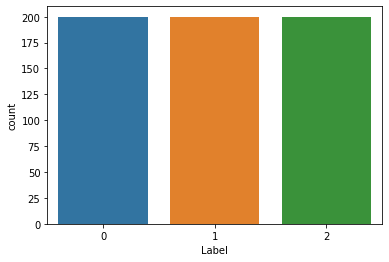

In [12]:
sns.countplot(train_with_labels['Label'], label='Sum')
plt.show()

## Test

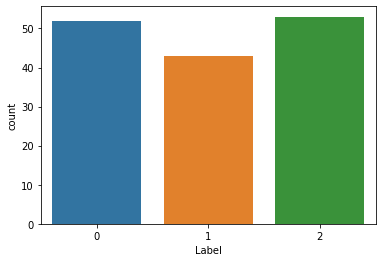

In [13]:
sns.countplot(test_with_labels['Label'], label='Sum')
plt.show()

# Train model on all features

In [9]:
def get_score_for_model(n_splits=10):
    seed = 13

    results = []
    names = []
    scoring = 'accuracy'

    for name, model in models:
        strat = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)

        cv_results = cross_val_score(model, X_train, y_train, cv=strat, scoring=scoring, n_jobs=-1)

        results.append(cv_results)
        names.append(name)

        print(f"{name}: {cv_results.mean()} ({cv_results.std()})")
        
    return results

In [10]:
def append_res_to_boxplot(results, df):
    i = 0
    while i < len(results[0]):
        line = []
        for num, ml in zip(results, mod_list): 
            line.append([num[i],ml])

        i = i+1
        df = df.append(pd.DataFrame(line, columns=['Score', 'ML']),ignore_index=True)
    return df

In [37]:
df_train = pd.read_csv('dataframes/train_with_labels.csv')
df_test = pd.read_csv('dataframes/test_with_labels.csv')

y_train = df_train['Label']
y_test = df_test['Label']

X_train = df_train.drop(['Label', 'image_name', 'ratio'], axis=1)
X_test = df_test.drop(['Label', 'image_name', 'ratio'], axis=1)

#Scaling
scaller = StandardScaler()
X_train = scaller.fit_transform(X_train)
X_test = scaller.fit_transform(X_test)

In [42]:
# df_train = df_train.drop(['ratio'], axis=1)
# df_test = df_test.drop(['ratio'], axis=1)

df_train.iloc[:,1:-1] = X_train
df_test.iloc[:,1:-1] = X_test

df_train.to_csv('dataframes/train_with_labels_scalled.csv', index=False )
df_test.to_csv('dataframes/test_with_labels_scalled.csv', index=False)

In [38]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(600, 17)
(148, 17)
(600,)
(148,)


In [86]:
models = []
models.append(('LR', LogisticRegression(solver='saga', penalty='l1', class_weight="balanced")))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DecTree', DecisionTreeClassifier())) 
models.append(('RF', RandomForestClassifier())) 
models.append(('XGB', XGBClassifier()))
models.append(('GaussianNB', GaussianNB()))

In [88]:
results = get_score_for_model()

LR: 0.8833333333333334 (0.03248931448269654)
KNN: 0.8766666666666667 (0.038873012632301994)
DecTree: 0.8733333333333333 (0.04422166387140531)
RF: 0.8983333333333332 (0.024094720491334914)
XGB: 0.9033333333333333 (0.03858612300930076)
GaussianNB: 0.8800000000000001 (0.033166247903554)


In [89]:
df_boxplot = append_res_to_boxplot(results, df_boxplot)
df_boxplot

,Score,ML
0,0.816667,LR
1,0.833333,KNN
2,0.800000,DecTree
3,0.866667,RF
4,0.816667,XGB
5,0.816667,GaussianNB
6,0.900000,LR
7,0.933333,KNN
8,0.916667,DecTree
9,0.916667,RF


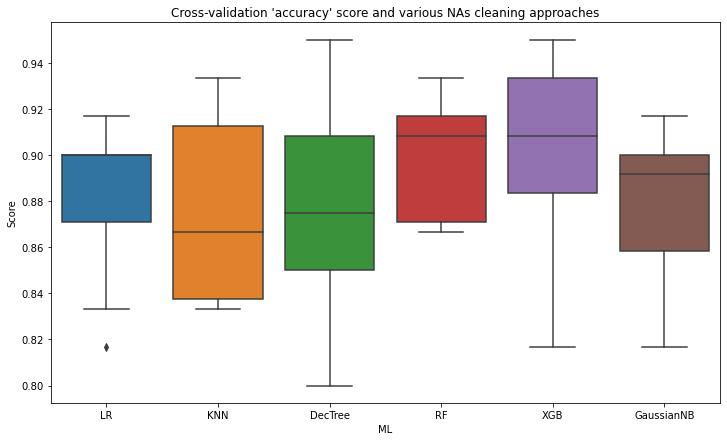

In [90]:
# Plotting the results 
plt.figure(figsize=(12,7))
plt.title("Cross-validation 'accuracy' score and various NAs cleaning approaches")
sns.boxplot(data = df_boxplot, x = 'ML',y='Score');

## XGBoost 

In [91]:
xgb = XGBClassifier(method='gpu_hist')

In [92]:
grid = {'nthread':[12], 
              'objective':['multy:logistic'],
              'learning_rate': [0.01,0.02], 
              'max_depth': [8,10,12,13,14],
              'min_child_weight': [4,5,6],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [20,30],
              'seed': [300]}

clf = GridSearchCV(xgb, grid, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='accuracy',
                   verbose=2, refit=True)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   44.1s finished


[21:14:13] WARNING: ../src/learner.cc:516: 
Parameters: { method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, method='gpu_hist',
                                     min_chil...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7],
                         'learning

In [93]:
clf.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 8,
 'min_child_weight': 6,
 'n_estimators': 30,
 'nthread': 12,
 'objective': 'multy:logistic',
 'seed': 300,
 'subsample': 0.8}

In [94]:
clf.best_score_

0.8916666666666666

In [95]:
confusion_matrix(y_train, clf.predict(X_train))

array([[200,   0,   0],
       [  0, 165,  35],
       [  0,   5, 195]])

### Check on test set

In [96]:
accuracy_score(y_test, clf.predict(X_test))

0.5405405405405406

In [97]:
confusion_matrix(y_test, clf.predict(X_test))

array([[38, 14,  0],
       [ 3, 37,  3],
       [11, 37,  5]])

However, for training set we had good accuracy, but for test set accuracy is awful

## Random Forest

In [98]:
randomForest = RandomForestClassifier()

In [99]:
grid2 = { 
    'n_estimators': [3,4,5,6,7,8,9,10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['gini', 'entropy', 'accuracy']
}

clf2 = GridSearchCV(randomForest, grid2, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='accuracy',
                   verbose=2, refit=True)

clf2.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:    3.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'accuracy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy', verbose=2)

In [100]:
clf2.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 7}

In [101]:
clf2.best_score_

0.905

In [102]:
confusion_matrix(y_train, clf2.predict(X_train))

array([[200,   0,   0],
       [  0, 184,  16],
       [  0,   3, 197]])

### Check on test set

In [103]:
accuracy_score(y_test, clf2.predict(X_test))

0.5202702702702703

In [104]:
confusion_matrix(y_test, clf2.predict(X_test))

array([[38, 11,  3],
       [ 3, 27, 13],
       [ 5, 36, 12]])

Result is the same

# Choosing features

In [52]:
train_without_labels.columns

Index(['image_name', 'thread_time_sift_lint', 'matches_good_ratio_sift_lint',
       'localization_error_l1_mean_sift_lint',
       'localization_error_l2_mean_sift_lint', 'thread_time_akaze_lint',
       'matches_good_ratio_akaze_lint',
       'localization_error_l1_mean_akaze_lint',
       'localization_error_l2_mean_akaze_lint', 'thread_time_sift_sang',
       'matches_good_ratio_sift_sang', 'localization_error_l1_mean_sift_sang',
       'localization_error_l2_mean_sift_sang', 'ratio', 'pixels',
       'thread_time_akaze_sang', 'matches_good_ratio_akaze_sang',
       'localization_error_l1_mean_akaze_sang',
       'localization_error_l2_mean_akaze_sang'],
      dtype='object')

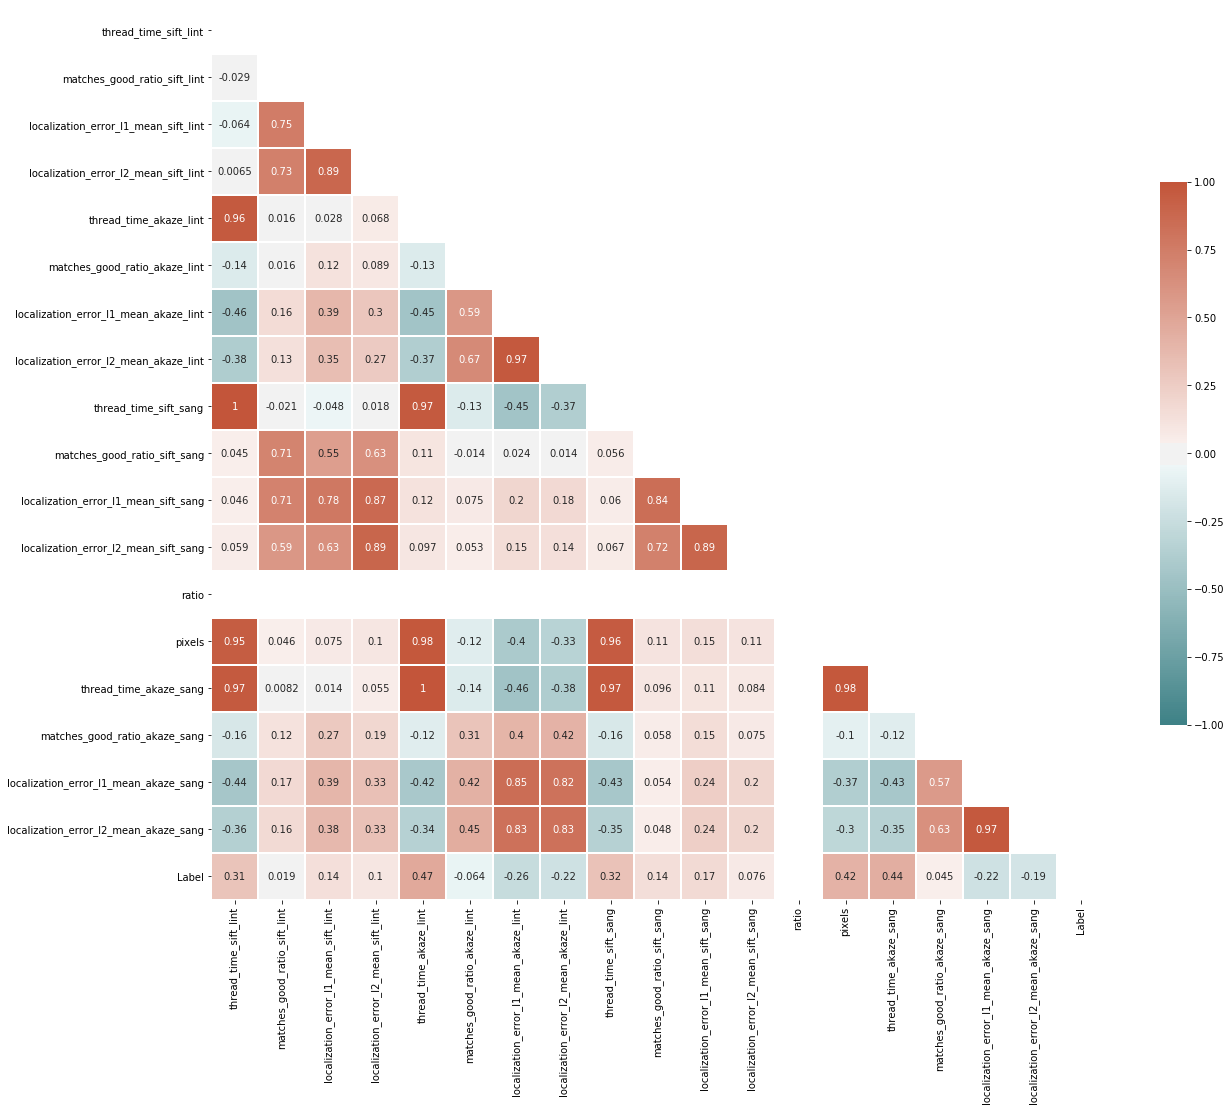

In [58]:
correlation = train_with_labels.corr()

features_counts = len(train_with_labels.columns)

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(features_counts, features_counts))

cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5,cbar_kws={'shrink': .5}, annot=True)

plt.show()

In [5]:
features = ['thread_time_sift_lint', 
            'localization_error_l1_mean_sift_lint',
            'localization_error_l2_mean_sift_lint',
            'thread_time_akaze_lint',
            'matches_good_ratio_sift_sang',
            'localization_error_l1_mean_sift_sang']

#saving features
file_name_features = 'features' 
dir_features = 'dataframes'
with open(f'{dir_features}/{file_name_features}.json', 'w') as outfile:
    dump(features, outfile)

In [103]:
df_train_features = train_with_labels[['Label'] + features]
df_test_features = test_with_labels[['Label'] + features]

df_train_features.to_csv('dataframes/df_train_features.csv', index=False)
df_train_features.to_csv('dataframes/df_test_features.csv', index=False)

## Scaling data

In [193]:
scaller = StandardScaler()

In [194]:
#Train
df_train_features = pd.read_csv('dataframes/df_train_features.csv')
X_train = df_train_features.drop(['Label'], axis=1)
y_train = df_train_features['Label']

#Test
df_test_features = pd.read_csv('dataframes/df_test_features.csv')
X_test = df_test_features.drop(['Label'], axis=1)
y_test = df_test_features['Label']

#Scaling data
X_train_scalling = scaller.fit_transform(X_train)
X_test_scalling = scaller.fit_transform(X_test)

In [195]:
X_train_scalling_df = pd.DataFrame(X_train_scalling, columns=X_train.columns)
X_test_scalling_df = pd.DataFrame(X_train_scalling, columns=X_train.columns)

X_train_scalling_df['Label'] = y_train
X_test_scalling_df['Label'] = y_test

In [197]:
#saving data
X_train_scalling_df.to_csv('dataframes/train_with_label_scaling.csv', index=False)
X_test_scalling_df.to_csv('dataframes/test_with_label_scaling.csv', index=False)

## Create models

In [198]:
#Train
df_train_features = pd.read_csv('dataframes/train_with_label_scaling.csv')
X_train = df_train_features.drop(['Label'], axis=1)
y_train = df_train_features['Label']

#Test
df_test_features = pd.read_csv('dataframes/test_with_label_scaling.csv')
X_test = df_test_features.drop(['Label'], axis=1)
y_test = df_test_features['Label']

In [200]:
models = []
models.append(('LR', LogisticRegression(solver='saga', penalty='l1', class_weight="balanced")))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DecTree', DecisionTreeClassifier())) 
models.append(('RF', RandomForestClassifier())) 
models.append(('XGB', XGBClassifier()))
models.append(('GaussianNB', GaussianNB()))

In [201]:
mod_list = []
for mod , _ in models:
    mod_list.append(mod)

mod_list.append('Cleaning')

df_boxplot = pd.DataFrame(columns=['Score', 'ML'])

In [203]:
results = get_score_for_model()

LR: 0.8833333333333334 (0.03073181485764296)
KNN: 0.8733333333333333 (0.030000000000000006)
DecTree: 0.86 (0.040960685758148346)
RF: 0.8983333333333332 (0.032871804872193364)
XGB: 0.8799999999999999 (0.035590260840104374)
GaussianNB: 0.8683333333333334 (0.03760171390892827)


In [205]:
df_boxplot = append_res_to_boxplot(results, df_boxplot)
df_boxplot

,Score,ML
0,0.816667,LR
1,0.883333,KNN
2,0.866667,DecTree
3,0.883333,RF
4,0.866667,XGB
5,0.816667,GaussianNB
6,0.900000,LR
7,0.916667,KNN
8,0.866667,DecTree
9,0.900000,RF


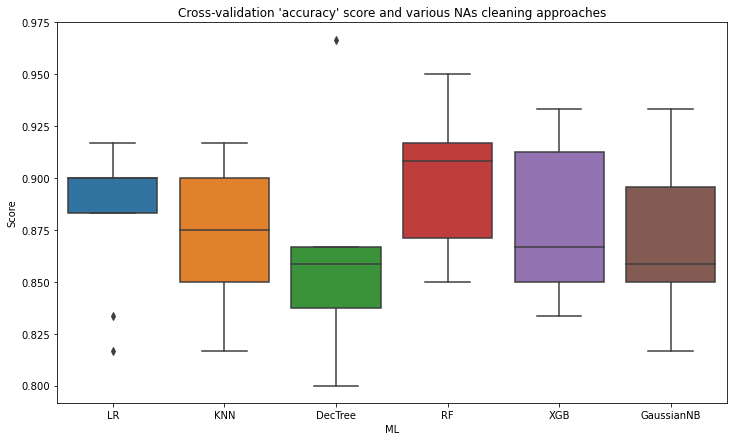

In [206]:
# Plotting the results 
plt.figure(figsize=(12,7))
plt.title("Cross-validation 'accuracy' score and various NAs cleaning approaches")
sns.boxplot(data = df_boxplot, x = 'ML',y='Score');

## Training model

In [40]:
#Train
df_train_features = pd.read_csv('dataframes/train_with_label_scaling.csv')
X_train = df_train_features.drop(['Label'], axis=1)
y_train = df_train_features['Label']

#Test
df_test_features = pd.read_csv('dataframes/test_with_label_scaling.csv')
X_test = df_test_features.drop(['Label'], axis=1)
y_test = df_test_features['Label']

## Xgboost

In [264]:
xgb = XGBClassifier(method='gpu_hist')

In [265]:
grid = {'nthread':[12], 
              'objective':['multy:logistic'],
              'learning_rate': [0.02,0.03], 
              'max_depth': [4,5],
              'min_child_weight': [5,6,7],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [10,15,20],
              'seed': [300]}

clf = GridSearchCV(xgb, grid, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='accuracy',
                   verbose=2, refit=True)

clf.fit(X_train, y_train)

In [268]:
clf.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.02,
 'max_depth': 5,
 'min_child_weight': 7,
 'n_estimators': 20,
 'nthread': 12,
 'objective': 'multy:logistic',
 'seed': 300,
 'subsample': 0.8}

In [269]:
clf.best_score_

0.8950000000000001

In [270]:
accuracy_score(y_test, clf.predict(X_test))

0.915

In [271]:
confusion_matrix(y_test, clf.predict(X_test))

array([[199,   1,   0],
       [  0, 153,  47],
       [  0,   3, 197]])

## Random Forest

In [216]:
randomForest = RandomForestClassifier()

In [219]:
grid2 = { 
    'n_estimators': [3,4,5,6,7,8,9,10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['gini', 'entropy', 'accuracy']
}

clf2 = GridSearchCV(randomForsst, grid2, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='accuracy',
                   verbose=2, refit=True)

clf2.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2117 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:    4.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=3), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'accuracy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy', verbose=2)

In [220]:
clf2.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 6}

In [221]:
clf2.best_score_

0.9049999999999999

In [222]:
accuracy_score(y_test, clf2.predict(X_test))

0.9466666666666667

In [223]:
confusion_matrix(y_test, clf2.predict(X_test))

array([[200,   0,   0],
       [  0, 173,  27],
       [  0,   5, 195]])

## NaiveBayes

In [248]:
naiveBayes = GaussianNB()

In [249]:
grid3 = { 
    'var_smoothing': np.linspace(1e-20, 1e-8, num=20)}

In [250]:
clf3 = GridSearchCV(naiveBayes, grid3, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='accuracy',
                   verbose=2, refit=True)

In [251]:
clf3.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e-20, 5.26315789e-10, 1.05263158e-09, 1.57894737e-09,
       2.10526316e-09, 2.63157895e-09, 3.15789474e-09, 3.68421053e-09,
       4.21052632e-09, 4.73684211e-09, 5.26315789e-09, 5.78947368e-09,
       6.31578947e-09, 6.84210526e-09, 7.36842105e-09, 7.89473684e-09,
       8.42105263e-09, 8.94736842e-09, 9.47368421e-09, 1.00000000e-08])},
             scoring='accuracy', verbose=2)

In [252]:
clf3.best_params_

{'var_smoothing': 1e-20}

In [253]:
clf3.best_score_

0.8700000000000001

In [254]:
accuracy_score(y_test, clf3.predict(X_test))

0.8683333333333333

In [255]:
confusion_matrix(y_test, clf3.predict(X_test))

array([[194,   6,   0],
       [  0, 137,  63],
       [  0,  10, 190]])

## Ensemble

In [41]:
clf4=XGBClassifier(colsample_bytree=0.7,
                  learning_rate=0.02,
                  max_depth=5,
                  min_child_weight=7,
                  n_estimators=20,
                  objective='multy:logistic',
                  seed=300,
                  subsample=0.8,
                  tree_method='gpu_hist')

clf5=RandomForestClassifier(criterion='entropy',
                           max_depth=8,
                           max_features='sqrt',
                           n_estimators=6,
                            n_jobs=-1)

clf6=GaussianNB(var_smoothing =  1e-20)

## Time for training every models

In [42]:
#XGBClassifier
%%time
clf4 = clf4.fit(X_train, y_train)

CPU times: user 695 ms, sys: 23.1 ms, total: 718 ms
Wall time: 77.2 ms


In [43]:
# RandomForestClassifier
%%time
clf5 = clf5.fit(X_train, y_train)

CPU times: user 19 ms, sys: 8.71 ms, total: 27.7 ms
Wall time: 107 ms


In [44]:
# GaussianNB
%%time
clf6 = clf6.fit(X_train, y_train)

CPU times: user 3.91 ms, sys: 0 ns, total: 3.91 ms
Wall time: 2.8 ms


In [277]:
prediction1 = clf4.predict(X_test)
prediction2 = clf5.predict(X_test)
prediction3 = clf6.predict(X_test)
pred_averaged = [np.round(np.mean([p1, p2, p3])) for p1,p2,p3 in zip(prediction1, prediction2,prediction3)]

In [278]:
print('Accuracy score:', accuracy_score(y_test, pred_averaged))
print('Confusion matrix: \n', confusion_matrix(y_test, pred_averaged))

Accuracy score: 0.9083333333333333
Confusion matrix: 
 [[199   1   0]
 [  0 146  54]
 [  0   0 200]]


In [279]:
print(classification_report(y_test, pred_averaged))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       200
           1       0.99      0.73      0.84       200
           2       0.79      1.00      0.88       200

    accuracy                           0.91       600
   macro avg       0.93      0.91      0.91       600
weighted avg       0.93      0.91      0.91       600



###  Voting 

### Voting 3 models: **XGBoost**, **RandomForest**, NaiveBayes

In [282]:
from sklearn.ensemble import VotingClassifier
ensemble3=VotingClassifier(estimators=[('Clf4', clf4), ('Clf5', clf5)], 
                       voting='soft').fit(X_train, y_train)

In [286]:
pred_vc = ensemble3.predict(X_test)
print('Accuracy score', accuracy_score(y_test, pred_vc))
print('Confusion matrix\n', confusion_matrix(y_test, pred_vc))

Accuracy score 0.885
Confusion matrix
 [[199   1   0]
 [  0 136  64]
 [  0   4 196]]


### Voting 2 models: **XGBoost**, **RandomForest**

In [284]:
ensemble2=VotingClassifier(estimators=[('Clf4', clf4), ('Clf5', clf5)], 
                       voting='soft').fit(X_train, y_train)

In [287]:
pred_vc = ensemble2.predict(X_test)
print('Accuracy score', accuracy_score(y_test, pred_vc))
print('Confusion matrix\n', confusion_matrix(y_test, pred_vc))

Accuracy score 0.9383333333333334
Confusion matrix
 [[200   0   0]
 [  0 168  32]
 [  0   5 195]]


In [288]:
print(classification_report(y_test, pred_vc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.97      0.84      0.90       200
           2       0.86      0.97      0.91       200

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



## Saving models

In [290]:
filename_model_xgb = 'models/xgb.sav'
filename_model_randFor = 'models/randomForest.sav'
filename_model_naiveBayes = 'models/naiveBayes.sav'
filename_model_combine2 = 'models/combine2.sav'
filename_model_combine3 = 'models/combine3.sav'

pickle.dump(clf4, open(filename_model_xgb, 'wb'))
pickle.dump(clf5, open(filename_model_randFor, 'wb'))
pickle.dump(clf6, open(filename_model_naiveBayes, 'wb'))
pickle.dump(ensemble2, open(filename_model_combine2, 'wb'))
pickle.dump(ensemble3, open(filename_model_combine3, 'wb'))

In [295]:
loaded_model = pickle.load(open(filename_model_combine2, 'rb'))

accuracy_score(y_test, loaded_model.predict(X_test))

0.9383333333333334

Shose 2 voting model with **XGBoost**, **RandomForest**

# Working with video

In [11]:
def create_photos(file_name_video, perid_second=.5,save_dir_lint='lintroller', save_dir_sang='sanglasses'):

    listing = os.listdir(file_name_video)

    count=2
    for vid in listing:
        vid = f"{file_name_video}/{vid}"
        vidcap = cv2.VideoCapture(vid)
        def getFrame(sec):
            vidcap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
            hasFrames,image = vidcap.read()

            if hasFrames:
                cv2.imwrite(f"image_from_video/{save_dir_lint}/{count}.jpg", image)
                cv2.imwrite(f"image_from_video/{save_dir_sang}/{count}.jpg", image)
            return hasFrames

        sec = 0
        frameRate = perid_second # Change this number to 1 for each 1 second

        success = getFrame(sec)
        while success:
            count = count + 1
            sec = sec + frameRate
            sec = round(sec, 2)
            success = getFrame(sec)

In [12]:
file_name_video = 'video'
create_photos(file_name_video)

In [ ]:
# Create metrics
descriptor_name='sift'
directory_train_name='image_from_video/sanglasses/'
json_dump_name='frames_video_sanglasses_sift'
name_directory_dump = 'frames_video_dumps'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)


descriptor_name='akaze'
directory_train_name='image_from_video/sanglasses/'
json_dump_name='frames_video_sanglasses_akaze'
name_directory_dump = 'frames_video_dumps'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

In [22]:
# Prepared format data for model
directory_dump = 'frames_video_dumps'
file_name_json_lintroller_sift = 'frames_video_lintroller_sift'
file_name_json_lintroller_akaze = 'frames_video_lintroller_akaze'
file_name_json_sandglass_sift = 'frames_video_sanglasses_sift'
file_name_json_sandglass_akaze = 'frames_video_sanglasses_akaze'

prepared = prepared_data(directory_dump, file_name_json_lintroller_sift,file_name_json_lintroller_akaze,file_name_json_sandglass_sift,file_name_json_sandglass_akaze)


metrices_lintroller_sift:	(29, 5)
metrices_lintroller_akaze:	(29, 5)
metrices_sandglass_sift:	(30, 5)
metrices_sandglass_akaze:	(30, 7)


In [23]:
prepared.head()

,image_name,thread_time_sift_lint,matches_good_ratio_sift_lint,localization_error_l1_mean_sift_lint,localization_error_l2_mean_sift_lint,thread_time_akaze_lint,matches_good_ratio_akaze_lint,localization_error_l1_mean_akaze_lint,localization_error_l2_mean_akaze_lint,thread_time_sift_sang,matches_good_ratio_sift_sang,localization_error_l1_mean_sift_sang,localization_error_l2_mean_sift_sang,ratio,pixels,thread_time_akaze_sang,matches_good_ratio_akaze_sang,localization_error_l1_mean_akaze_sang,localization_error_l2_mean_akaze_sang
0,10,0.048165,0.044211,28.751895,1725.851182,0.061299,0.053488,19.997674,674.988372,0.047088,0.044211,28.751895,1725.851182,0.75,307200,0.061407,0.053488,19.997674,674.988372
1,11,0.045483,0.000000,17.766217,602.662082,0.050551,0.034884,14.683721,391.944186,0.048116,0.000000,17.766217,602.662082,0.75,307200,0.050885,0.034884,14.683721,391.944186
2,13,0.047536,0.088421,36.206125,3982.531631,0.058636,0.023256,11.362791,226.823256,0.047566,0.088421,36.206125,3982.531631,0.75,307200,0.051746,0.023256,11.362791,226.823256
3,14,0.047662,0.046316,48.193236,3454.370873,0.050315,0.023256,9.690698,178.462791,0.049794,0.046316,48.193236,3454.370873,0.75,307200,0.054425,0.023256,9.690698,178.462791
4,15,0.046984,0.115789,47.988300,4157.504136,0.050598,0.025581,9.190698,164.209302,0.047594,0.115789,47.988300,4157.504136,0.75,307200,0.058710,0.025581,9.190698,164.209302


In [24]:
prepared.to_csv('dataframes/from_video_prepared.csv', index=False)

## Computed prediction for video frames

In [4]:
file_name_features = 'features' 
dir_features = 'dataframes'
with open(f'{dir_features}/{file_name_features}.json') as json_file:
    features = load(json_file)

prepared = pd.read_csv('dataframes/from_video_prepared.csv')
prepared.head()

,image_name,thread_time_sift_lint,matches_good_ratio_sift_lint,localization_error_l1_mean_sift_lint,localization_error_l2_mean_sift_lint,thread_time_akaze_lint,matches_good_ratio_akaze_lint,localization_error_l1_mean_akaze_lint,localization_error_l2_mean_akaze_lint,thread_time_sift_sang,matches_good_ratio_sift_sang,localization_error_l1_mean_sift_sang,localization_error_l2_mean_sift_sang,ratio,pixels,thread_time_akaze_sang,matches_good_ratio_akaze_sang,localization_error_l1_mean_akaze_sang,localization_error_l2_mean_akaze_sang
0,10,0.048165,0.044211,28.751895,1725.851182,0.061299,0.053488,19.997674,674.988372,0.047088,0.044211,28.751895,1725.851182,0.75,307200,0.061407,0.053488,19.997674,674.988372
1,11,0.045483,0.000000,17.766217,602.662082,0.050551,0.034884,14.683721,391.944186,0.048116,0.000000,17.766217,602.662082,0.75,307200,0.050885,0.034884,14.683721,391.944186
2,13,0.047536,0.088421,36.206125,3982.531631,0.058636,0.023256,11.362791,226.823256,0.047566,0.088421,36.206125,3982.531631,0.75,307200,0.051746,0.023256,11.362791,226.823256
3,14,0.047662,0.046316,48.193236,3454.370873,0.050315,0.023256,9.690698,178.462791,0.049794,0.046316,48.193236,3454.370873,0.75,307200,0.054425,0.023256,9.690698,178.462791
4,15,0.046984,0.115789,47.988300,4157.504136,0.050598,0.025581,9.190698,164.209302,0.047594,0.115789,47.988300,4157.504136,0.75,307200,0.058710,0.025581,9.190698,164.209302


In [5]:
file_names_images = prepared.image_name
prepared = prepared[features]

In [6]:
scaller = StandardScaler()
prepared_normalices = scaller.fit_transform(prepared)
prepared_normalices = pd.DataFrame(prepared_normalices, columns=features)
prepared_normalices.head()

,thread_time_sift_lint,localization_error_l1_mean_sift_lint,localization_error_l2_mean_sift_lint,thread_time_akaze_lint,matches_good_ratio_sift_sang,localization_error_l1_mean_sift_sang
0,0.180008,-0.541831,-0.559114,1.765560,-0.339676,-0.541831
1,-1.133411,-1.680947,-1.350191,-1.254338,-1.227499,-1.680947
2,-0.127822,0.231105,1.030294,1.017298,0.548147,0.231105
3,-0.066182,1.474061,0.658304,-1.320527,-0.297399,1.474061
4,-0.398047,1.452811,1.153530,-1.241150,1.097752,1.452811


In [7]:
file_name_model = 'models/combine2.sav'
loaded_model = pickle.load(open(file_name_model, 'rb'))
predictions = loaded_model.predict(prepared_normalices)
# predictions = loaded_model.predict(prepared)

In [25]:
values_rea1 = [10, 11, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 4, 5, 6, 7, 8, 9]
values_real = [1,  1,   2,  2,  2,  2,  2,  2,  2, 1, 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2, 2,  1, 1, 1, 1, 1, 1]

In [26]:
pd.DataFrame({'file_name':file_names_images, 'prediction':predictions, 'class':values_real})

,file_name,prediction,class
0,10,1,1
1,11,0,1
2,13,1,2
3,14,0,2
4,15,2,2
5,16,2,2
6,17,2,2
7,18,0,2
8,19,0,2
9,2,1,1


## Create prediction using normalization from training set

In [27]:
train_set = pd.read_csv('dataframes/train_with_label_scaling.csv')

In [28]:
X_train = train_set.drop(['Label'], axis=1)
means_features = X_train.mean(axis=0)
var_features = X_train.var(axis=0)

In [29]:
means_features.shape

(6,)

In [30]:
means_features.values

array([-2.75913551e-16,  7.30804306e-16, -1.20459198e-16,  1.34319639e-16,
       -2.97354733e-16,  1.79948649e-16])

In [31]:
file_name_features = 'features' 
dir_features = 'dataframes'
with open(f'{dir_features}/{file_name_features}.json') as json_file:
    features = load(json_file)

prepared = pd.read_csv('dataframes/from_video_prepared.csv')
prepared.head()

,image_name,thread_time_sift_lint,matches_good_ratio_sift_lint,localization_error_l1_mean_sift_lint,localization_error_l2_mean_sift_lint,thread_time_akaze_lint,matches_good_ratio_akaze_lint,localization_error_l1_mean_akaze_lint,localization_error_l2_mean_akaze_lint,thread_time_sift_sang,matches_good_ratio_sift_sang,localization_error_l1_mean_sift_sang,localization_error_l2_mean_sift_sang,ratio,pixels,thread_time_akaze_sang,matches_good_ratio_akaze_sang,localization_error_l1_mean_akaze_sang,localization_error_l2_mean_akaze_sang
0,10,0.048165,0.044211,28.751895,1725.851182,0.061299,0.053488,19.997674,674.988372,0.047088,0.044211,28.751895,1725.851182,0.75,307200,0.061407,0.053488,19.997674,674.988372
1,11,0.045483,0.000000,17.766217,602.662082,0.050551,0.034884,14.683721,391.944186,0.048116,0.000000,17.766217,602.662082,0.75,307200,0.050885,0.034884,14.683721,391.944186
2,13,0.047536,0.088421,36.206125,3982.531631,0.058636,0.023256,11.362791,226.823256,0.047566,0.088421,36.206125,3982.531631,0.75,307200,0.051746,0.023256,11.362791,226.823256
3,14,0.047662,0.046316,48.193236,3454.370873,0.050315,0.023256,9.690698,178.462791,0.049794,0.046316,48.193236,3454.370873,0.75,307200,0.054425,0.023256,9.690698,178.462791
4,15,0.046984,0.115789,47.988300,4157.504136,0.050598,0.025581,9.190698,164.209302,0.047594,0.115789,47.988300,4157.504136,0.75,307200,0.058710,0.025581,9.190698,164.209302


In [32]:
file_names_images = prepared.image_name
prepared = prepared[features]

In [33]:
prepared.values.shape

(29, 6)

In [34]:
prepared_normalices = (prepared.values - means_features.values) / var_features.values

In [35]:
prepared_normalices.shape

(29, 6)

In [36]:
file_name_model = 'models/combine2.sav'
loaded_model = pickle.load(open(file_name_model, 'rb'))
predictions = loaded_model.predict(prepared_normalices)

In [37]:
predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2])

In [39]:
pd.DataFrame({'file_name' : file_names_images, 'predictions': predictions, 'class':values_real})

,file_name,predictions,class
0,10,2,1
1,11,2,1
2,13,2,2
3,14,2,2
4,15,2,2
5,16,2,2
6,17,2,2
7,18,2,2
8,19,2,2
9,2,2,1


## Building neural network (Deep-NN, Conv-NN)

## Preparing data for TensorFlow

In [44]:
from os import walk
from PIL import Image


def pretrain_data(input_directory, output_directory, size=(150,150)):
    
    print(f'dir:\t{input_directory}')
    try:    
        os.mkdir(output_directory) 
    except FileExistsError:
        pass
    
    f = []
    for (dirpath, dirnames, filenames) in walk(input_directory):
        f.extend(filenames)
        break
    
    for image_name in sorted(f):
        
        print(f'image:\t{image_name}')
        image1 = Image.open(f'{input_directory}/{image_name}')

        img_resized = image1.resize(size)
        img_resized.save(f'{output_directory}/{image_name}')

In [45]:
def get_list_images(input_directory):
    print(input_directory)
    f = []
    for (dirpath, dirnames, filenames) in walk(input_directory):
        f.extend(filenames)
        break
    f_sorted = sorted(f)
#     print(f_sorted)
    train_set_images = [Image.open(f'{input_directory}/{image_name}') for image_name in f_sorted]
    
    images_get = ([np.array(x,  dtype=float) for x in train_set_images])
    
    for i, image in enumerate(images_get):
    
        if len(image.shape) != 3:
            print(f'THIS_____{i}')
            print(f_sorted[i])
            del f_sorted[i]
            del images_get[i]

    images_get = np.array(images_get)
#     images_get = np.zeros(shape=(, 4))

    return  images_get, np.array([name[:-4] for name in f_sorted])

In [ ]:
input_directory = 'test_160/lintroller/'
output_directory = 'test_160_prepared/'
pretrain_data(input_directory, output_directory)

## Create model

<a href='https://www.tensorflow.org/tutorials/images/classification'> Source Link</a>

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
from sklearn.model_selection import train_test_split

## Turn on GPU for tensorflow

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Simple neural network

## For tabular data

In [5]:
def plot_accuracy_loss_nn(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Choosing all features

In [6]:
class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if log.get('accuracy') > 0.99:
            self.model.stop_training = True

callback = MyCallBack()

In [7]:
# df_train.to_csv('dataframes/train_with_labels_scalled.csv')
# df_test.to_csv('dataframes/test_with_labels_scalled.csv')

#Train
df_train_features = pd.read_csv('dataframes/train_with_labels_scalled.csv')
X_train = df_train_features.drop(['Label', 'image_name'], axis=1)
y_train = df_train_features['Label']

#Test
df_test_features = pd.read_csv('dataframes/test_with_labels_scalled.csv')
X_test = df_test_features.drop(['Label', 'image_name'], axis=1)
y_test = df_test_features['Label']

validation_split = 0.2
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_split, random_state=1)

In [8]:
print('train:')
print(X_train.shape)
print(y_train.shape)

print('\nvalidation:')
print(X_validation.shape)
print(y_validation.shape)

print('\ntest:')
print(X_test.shape)
print(y_test.shape)

train:
(480, 17)
(480,)

validation:
(120, 17)
(120,)

test:
(148, 17)
(148,)


In [11]:
%%time
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1,17)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

opt = tf.keras.optimizers.Adam(
    learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.SUM,
    name='sparse_categorical_crossentropy'
)

model1.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy'])
epochs = 200
batch_size = 5
validation_split=0.2
history = model1.fit(x=X_train, 
                     y=y_train, 
                     epochs=epochs, 
                     validation_split=validation_split,
                     batch_size=batch_size,
                    callbacks=[callback])

Epoch 1/200
77/77 [==============================] - 0s 2ms/step - loss: 3.0896 - accuracy: 0.7161 - val_loss: 1.4310 - val_accuracy: 0.8750
Epoch 2/200
77/77 [==============================] - 0s 1ms/step - loss: 1.5956 - accuracy: 0.8750 - val_loss: 0.8876 - val_accuracy: 0.9479
Epoch 3/200
77/77 [==============================] - 0s 1ms/step - loss: 1.2391 - accuracy: 0.8906 - val_loss: 0.7908 - val_accuracy: 0.9479
Epoch 4/200
77/77 [==============================] - 0s 1ms/step - loss: 1.1420 - accuracy: 0.8958 - val_loss: 0.8037 - val_accuracy: 0.9479
Epoch 5/200
77/77 [==============================] - 0s 1ms/step - loss: 1.0752 - accuracy: 0.9089 - val_loss: 0.8097 - val_accuracy: 0.9375
Epoch 6/200
77/77 [==============================] - 0s 1ms/step - loss: 1.1036 - accuracy: 0.8906 - val_loss: 0.7336 - val_accuracy: 0.9375
Epoch 7/200
77/77 [==============================] - 0s 1ms/step - loss: 0.9681 - accuracy: 0.9089 - val_loss: 0.7465 - val_accuracy: 0.9375
Epoch 8/200
7

4/4 [==============================] - 0s 940us/step - loss: 18.8827 - accuracy: 0.9250


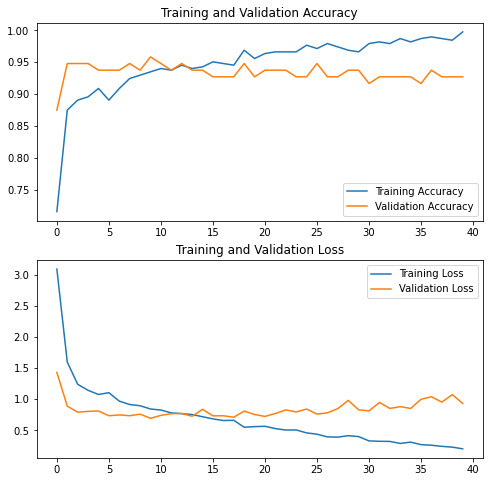

In [12]:
model1.evaluate(X_validation, y_validation)
plot_accuracy_loss_nn(history, epochs)

### After features preparation

In [138]:
with open('dataframes/features.json') as f: 
    features = load(f) + ['Label']

#Train
df_train_features = pd.read_csv('dataframes/train_with_labels_scalled.csv')[features]
X_train = df_train_features.drop(['Label'], axis=1)
y_train = df_train_features['Label']

#Test
df_test_features = pd.read_csv('dataframes/test_with_labels_scalled.csv')[features]
X_test = df_test_features.drop(['Label'], axis=1)
y_test = df_test_features['Label']

validation_split = 0.2
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_split, random_state=1)

In [139]:
print('train:')
print(X_train.shape)
print(y_train.shape)

print('\nvalidation:')
print(X_validation.shape)
print(y_validation.shape)

print('\ntest:')
print(X_test.shape)
print(y_test.shape)

train:
(480, 6)
(480,)

validation:
(120, 6)
(120,)

test:
(148, 6)
(148,)


In [151]:
%%time
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1,6)),
    keras.layers.Dense(16, activation=tf.nn.softmax),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.SUM,
    name='sparse_categorical_crossentropy'
)
model1.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy'])
epochs = 400

validation_split = 0.2
batch_size = 5
history = model1.fit(X_train, 
                     y_train,
                     epochs=epochs, 
                     validation_split=validation_split, 
                     batch_size=batch_size,
                    callbacks=[callback])

Epoch 1/400
77/77 [==============================] - 0s 2ms/step - loss: 5.4190 - accuracy: 0.4479 - val_loss: 5.1474 - val_accuracy: 0.5417
Epoch 2/400
77/77 [==============================] - 0s 1ms/step - loss: 5.0778 - accuracy: 0.5859 - val_loss: 4.5911 - val_accuracy: 0.7917
Epoch 3/400
77/77 [==============================] - 0s 1ms/step - loss: 4.4920 - accuracy: 0.7031 - val_loss: 3.7384 - val_accuracy: 0.9062
Epoch 4/400
77/77 [==============================] - 0s 1ms/step - loss: 3.7479 - accuracy: 0.8047 - val_loss: 2.9260 - val_accuracy: 0.9375
Epoch 5/400
77/77 [==============================] - 0s 1ms/step - loss: 3.0864 - accuracy: 0.8385 - val_loss: 2.2839 - val_accuracy: 0.9167
Epoch 6/400
77/77 [==============================] - 0s 1ms/step - loss: 2.5671 - accuracy: 0.8646 - val_loss: 1.8394 - val_accuracy: 0.9479
Epoch 7/400
77/77 [==============================] - 0s 2ms/step - loss: 2.2026 - accuracy: 0.8776 - val_loss: 1.5444 - val_accuracy: 0.9375
Epoch 8/400
7

4/4 [==============================] - 0s 1ms/step - loss: 12.9104 - accuracy: 0.8250


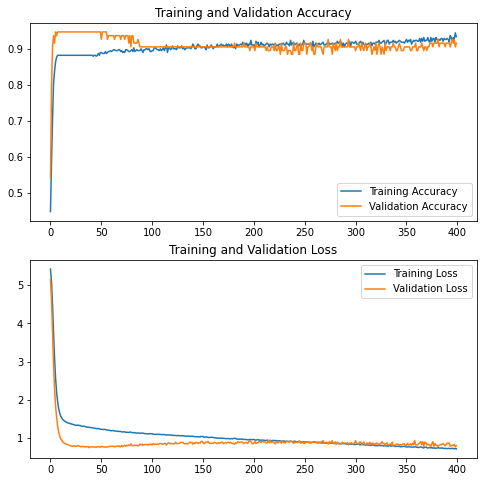

In [152]:
model1.evaluate(X_validation, y_validation)
plot_accuracy_loss_nn(history, epochs)

## CNN

In [92]:
batch_size = 10
img_height = 150
img_width = 150
data_dir = 'lab3_train_600_prepared'
validation_split=0.2

train_ds = keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size,
    shuffle=True)

Found 599 files belonging to 3 classes.
Using 480 files for training.


In [93]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size,
    shuffle=True)

Found 599 files belonging to 3 classes.
Using 119 files for validation.


In [94]:
class_names = train_ds.class_names
print(class_names)

['lintroller', 'nothing', 'sandglass']


## Visualize the data

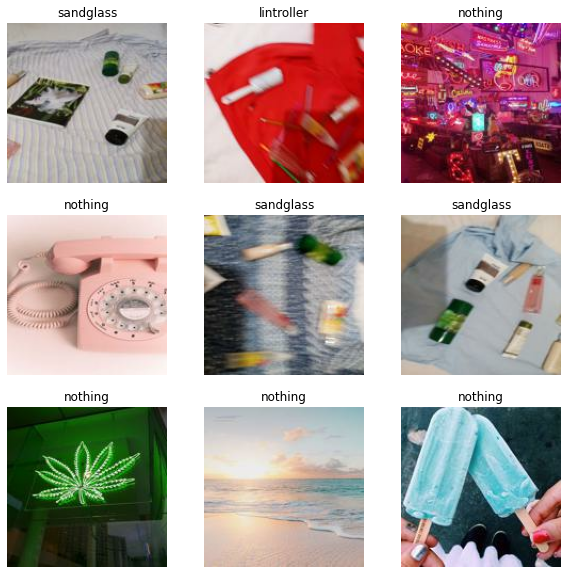

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

In [96]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 150, 150, 3)
(10,)


## Configure the dataset for performance

In [97]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(20).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [98]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image)) 

## Create the model

In [99]:
class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if log.get('accuracy') > 0.99:
            self.model.stop_training = True

callback = MyCallBack()     

In [101]:
num_classes = 3
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction=tf.keras.losses.Reduction.SUM,
    name='sparse_categorical_crossentropy')

model.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy'])
model.summary()

epochs=200
history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      callbacks=[callback]
)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 18, 64)      

12/12 [==============================] - 0s 3ms/step - loss: 9.0931 - accuracy: 0.7227


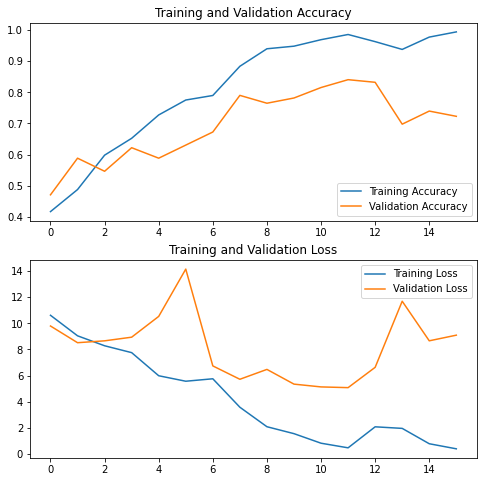

In [103]:
model.evaluate(val_ds)
plot_accuracy_loss_nn(history, epochs)

## Data augmentation

In [104]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

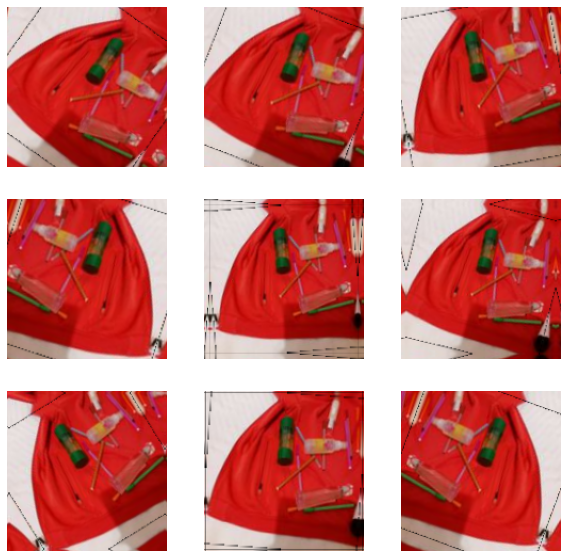

In [105]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Dropout

In [117]:
model2 = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1/255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction=tf.keras.losses.Reduction.SUM,
    name='sparse_categorical_crossentropy')

model2.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy'])
model2.summary()

epochs=200
history = model2.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      callbacks=[callback]
)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_19 (Sequential)   (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 37, 37, 64)      

12/12 [==============================] - 0s 3ms/step - loss: 13.4585 - accuracy: 0.7815


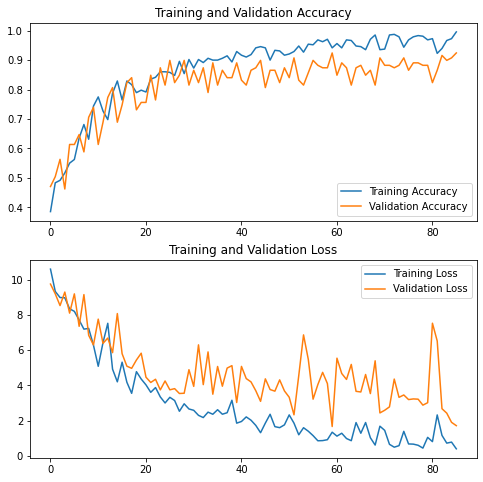

In [118]:
model.evaluate(val_ds)
plot_accuracy_loss_nn(history, epochs)